In [1]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt

# 用来绘图的，封装了matplot
# 要注意的是一旦导入了seaborn，
# matplotlib的默认作图风格就会被覆盖成seaborn的格式
import seaborn as sns       

from scipy import stats
from scipy.stats import  norm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# 为了在jupyter notebook里作图，需要用到这个命令
from sklearn.model_selection import train_test_split
#model
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
# linear regression
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from matplotlib.ticker import PercentFormatter
from pylab import rcParams
#rcParams['figure.figsize'] = 12, 10

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('redfin_2020-04-05-10-28-57.csv')

In [3]:
data.shape

(350, 27)

In [4]:
#drop unnecessary features
features_drop = ['SOLD DATE','ADDRESS','HOA/MONTH','STATUS','NEXT OPEN HOUSE START TIME','NEXT OPEN HOUSE END TIME',
                'URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)',
                'SOURCE','MLS#','DAYS ON MARKET','$/SQUARE FEET']
data = data.drop(features_drop,axis=1)

In [5]:
data.dtypes


SALE TYPE              object
PROPERTY TYPE          object
CITY                   object
STATE OR PROVINCE      object
ZIP OR POSTAL CODE      int64
PRICE                   int64
BEDS                  float64
BATHS                 float64
LOCATION               object
SQUARE FEET           float64
LOT SIZE              float64
YEAR BUILT            float64
FAVORITE               object
INTERESTED             object
LATITUDE              float64
LONGITUDE             float64
dtype: object

In [6]:
data.isnull().sum()

SALE TYPE              0
PROPERTY TYPE          0
CITY                   0
STATE OR PROVINCE      0
ZIP OR POSTAL CODE     0
PRICE                  0
BEDS                   6
BATHS                 21
LOCATION               0
SQUARE FEET            5
LOT SIZE              88
YEAR BUILT             5
FAVORITE               0
INTERESTED             0
LATITUDE               0
LONGITUDE              0
dtype: int64

In [7]:
data.shape

(350, 16)

## Data Cleansing

In [8]:
#fill in missing data
data['PRICE'].fillna(data['PRICE'].median(), inplace = True)
data['BEDS'].fillna(data['BEDS'].mode(), inplace = True)
data['BATHS'].fillna(data['BATHS'].mode(), inplace = True)
data['SQUARE FEET'].fillna(data['SQUARE FEET'].median(), inplace = True)
data['LOT SIZE'].fillna(data['LOT SIZE'].median(), inplace = True)

In [9]:
#drop rows with missing location
data.dropna(subset=['LOCATION'], inplace=True)
data.dropna(subset=['YEAR BUILT'], inplace=True)

In [10]:
#rename features
data = data.rename(columns={'SQUARE FEET':'SQUARE_FEET',
                            'LOT SIZE':'LOT_SIZE',
                            'YEAR BUILT':'YEAR_BUILT'})

In [11]:
data.describe()

,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,SQUARE_FEET,LOT_SIZE,YEAR_BUILT,LATITUDE,LONGITUDE
count,345.000000,3.450000e+02,344.000000,329.000000,345.000000,3.450000e+02,345.000000,345.000000,345.000000
mean,95121.234783,1.167971e+06,3.133721,2.278875,1776.585507,9.682635e+03,1976.915942,37.299906,-121.874262
std,22.209362,7.739502e+05,1.142664,0.865102,1375.632271,5.945650e+04,24.257974,0.050424,0.061851
min,95008.000000,7.290000e+04,0.000000,1.000000,1.000000,5.600000e+02,1901.000000,37.156595,-122.030339
25%,95120.000000,7.988880e+05,2.000000,2.000000,1248.000000,5.519000e+03,1961.000000,37.264511,-121.914354
50%,95125.000000,9.990000e+05,3.000000,2.000000,1510.000000,6.097000e+03,1973.000000,37.295591,-121.875229
75%,95131.000000,1.390000e+06,4.000000,2.500000,1958.000000,6.927000e+03,1995.000000,37.326169,-121.833909
max,95148.000000,9.000000e+06,9.000000,6.500000,19200.000000,1.105652e+06,2020.000000,37.417819,-121.738526


In [12]:
data.head()

,SALE TYPE,PROPERTY TYPE,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,LOCATION,SQUARE_FEET,LOT_SIZE,YEAR_BUILT,FAVORITE,INTERESTED,LATITUDE,LONGITUDE
0,MLS Listing,Condo/Co-op,SAN JOSE,CA,95111,849777,3.0,3.5,SAN JOSE,1848.0,6097.0,2016.0,N,Y,37.292888,-121.851557
1,MLS Listing,Single Family Residential,SAN JOSE,CA,95123,958800,3.0,2.0,SAN JOSE,1232.0,6159.0,1971.0,N,Y,37.241370,-121.828082
2,MLS Listing,Townhouse,SAN JOSE,CA,95129,1200000,2.0,2.5,SAN JOSE,1350.0,834.0,2005.0,N,Y,37.294228,-121.991764
3,MLS Listing,Condo/Co-op,SAN JOSE,CA,95134,750000,2.0,2.0,SAN JOSE,850.0,6097.0,1993.0,N,Y,37.414943,-121.957787
4,Redfin Data,Condo/Co-op,San Jose,CA,95135,399999,2.0,2.0,San Jose,1223.0,1306.0,1972.0,N,Y,37.297445,-121.757262


In [13]:
data.isnull().sum()

SALE TYPE              0
PROPERTY TYPE          0
CITY                   0
STATE OR PROVINCE      0
ZIP OR POSTAL CODE     0
PRICE                  0
BEDS                   1
BATHS                 16
LOCATION               0
SQUARE_FEET            0
LOT_SIZE               0
YEAR_BUILT             0
FAVORITE               0
INTERESTED             0
LATITUDE               0
LONGITUDE              0
dtype: int64

## Exploratory Data Analysis

TypeError: ufunc 'sqrt' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

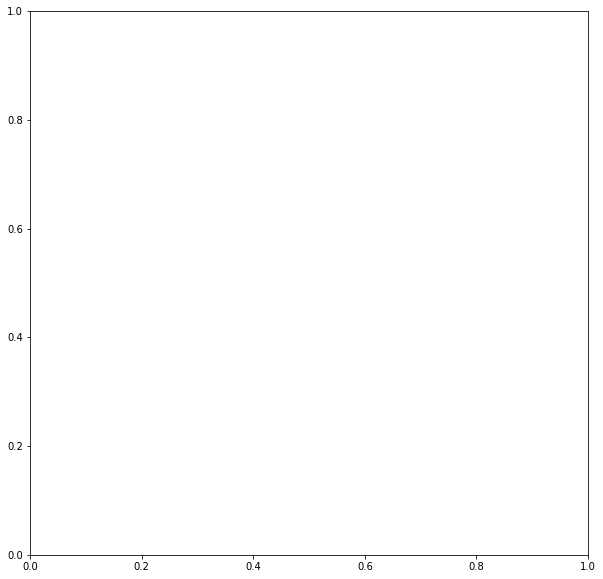

In [14]:
data.plot(kind='scatter',x='LONGITUDE',y='LATITUDE',alpha=0.4,
         s='SQUARE_FEET',label='SQUARE_FEET',figsize=(10,10),
         c='PRICE',cmap=plt.get_cmap('jet'),colorbar=True)

In [ ]:
ax = sns.countplot('BEDS',data=data)

In [ ]:
sns.boxplot('PRICE',data=data)

In [ ]:
sns.distplot(data["PRICE"])

In [ ]:
#price vs. beds
ax = sns.jointplot(x = 'BEDS', y = 'PRICE', data = data, kind='reg')
#plt.xlim([0,10])
#plt.ylim([0,1000000]);

In [ ]:
sns.regplot(x='PRICE',y='SQUARE_FEET',data=data)


In [ ]:
#price vs. areas
ax = sns.scatterplot(x = 'SQUARE_FEET', y = 'PRICE', data = data, s = 50, color = 'dodgerblue')
plt.figure(figsize=(15,5))
#plt.xlim([0,10])
#plt.ylim([0,1000000]);

In [ ]:
#price vs. areas
ax = sns.scatterplot(x = 'LOCATION', y = 'PRICE', data = data, s = 50, color = 'dodgerblue')


In [ ]:
#latitude and longitude vs. price
plt.scatter((data['LATITUDE']+data['LONGITUDE']), data['PRICE'],color = 'dodgerblue')


In [ ]:
#price vs. beds and baths counts
plt.scatter((data['BEDS']+data['BATHS']), data['PRICE'],color = 'dodgerblue')


In [ ]:
%pylab inline
pylab.rcParams['figure.figsize']=(15,10)
corrmatrix = data.corr()
sns.heatmap(corrmatrix,square=True,vmax=1,vmin=-1,center=0,cmap='coolwarm')

In [ ]:
# Correlating Features
plt.figure(figsize=(15,10))
colormap = sns.diverging_palette(220, 10, as_cmap = True)
sns.heatmap(data.corr(), cmap=colormap, vmax=0.6, square=True, annot=True)

In [ ]:
data.plot(kind='scatter', x='LONGITUDE', y='LATITUDE',)

In [ ]:
corr = data.corr()
corr.style.background_gradient(cmap=colormap, low=.5, high=0).highlight_null('red')

### Model

In [ ]:
feature_data = data.drop(['PRICE'],axis=1)
target_data = data['PRICE']
X_train,X_test,y_train, y_test = train_test_split(feature_data, target_data, test_size=0.3)

In [ ]:
print(len(y_train), 'Train\n', len(X_test), 'Test')

In [ ]:
df_train = pd.concat([X_train,y_train],axis=1)
# ols("target~feature+C(feature)", data=data
# C(feature)表示这个特征为分类特征category

linear_regression = smf.ols(formula='PRICE ~ + BEDS + BATHS + LATITUDE + LONGITUDE + SQUARE_FEET + LOT_SIZE+ YEAR_BUILT', data=df_train)
fitted_model = linear_regression.fit()
fitted_model.summary()

# Lasso and Ridge

In [ ]:
#Define input array with angles from 60deg to 300deg converted to radians
x = np.array([i*np.pi/180 for i in range(60,300,4)])
np.random.seed(10)  #Setting seed for reproducability
y = np.sin(x) + np.random.normal(0,0.15,len(x))
data = pd.DataFrame(np.column_stack([x,y]),columns=['PRICE','SQUARE_FEET'])
plt.plot(data['PRICE'],data['SQUARE_FEET'],'.')

In [ ]:
for i in range(2,16):  #power of 1 is already there
    colname = 'PRICE_%d'%i      #new var will be x_power
    data[colname] = data['PRICE']**i
data.head(3)

### Price vs. Square_feet

In [ ]:
#Import Linear Regression model from scikit-learn.
# Price vs. Square_feet
def linear_regression(data, power, models_to_plot):
    #initialize predictors:
    predictors=['PRICE']
    if power>=2:
        predictors.extend(['PRICE_%d'%i for i in range(2,power+1)])
    
    #Fit the model
    linreg = LinearRegression(normalize=True)
    linreg.fit(data[predictors],data['SQUARE_FEET'])
    y_pred = linreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered power
    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data['PRICE'],y_pred)
        plt.plot(data['PRICE'],data['SQUARE_FEET'],'.')
        plt.title('Plot for power: %d'%power)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['SQUARE_FEET'])**2)
    ret = [rss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

In [ ]:
#Initialize a dataframe to store the results:
col = ['rss','intercept'] + ['PRICE_%d'%i for i in range(1,16)]
ind = ['PRICE_%d'%i for i in range(1,16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)


In [ ]:
#Define the powers for which a plot is required:
models_to_plot = {1:231,3:232,6:233,9:234,12:235,15:236}


In [ ]:
#Iterate through all powers and assimilate results
for i in range(1,16):
    coef_matrix_simple.iloc[i-1,0:i+2] = linear_regression(data, power=i, models_to_plot=models_to_plot)

In [ ]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

In [ ]:
def ridge_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    
    ridgereg.fit(data[predictors],data['SQUARE_FEET'])
    y_pred = ridgereg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['PRICE'],y_pred)
        plt.plot(data['PRICE'],data['SQUARE_FEET'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['SQUARE_FEET'])**2)
    aic = len(data)*np.log(rss/len(data)) + 2*(len(data.columns)-1)
    ret = [rss]
    ret.extend([aic])
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

In [ ]:
#Initialize predictors to be set of 15 powers of x
predictors=['PRICE']
predictors.extend(['PRICE_%d'%i for i in range(2,16)])

#Set the different values of alpha to be tested
alpha_ridge = [1e-15, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, .5e-1, 1, 5, 20]

#Initialize the dataframe for storing coefficients.
col = ['sse','aic','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1e-6:331, 1e-5:332, 1e-4:333, 1e-3:334, 1e-2:335, .5e-1:336, 1:337, 5:338, 20:339}
for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(data, predictors, alpha_ridge[i], models_to_plot)